# custom module

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt

## 1.定义模型

我们的目标是使用前n天的(click, pv)来预测新一天的ctr:<br>
$$\tilde{ctr}_{n + 1} = \frac{\sum_{i=1}^{n}click_{i}*param_{i} }{\sum_{i=1}^{n}pv_{i} * param_{i} } $$
所求为$param_{i}$。在ctr很稳定的理想状态，$param_{i}=1$。<br>
模型图示如下：

![jupyter](./custom_module.svg)

In [2]:
class TimeDecayModule(nn.Module):
    def __init__(self, num_input):
        super(TimeDecayModule, self).__init__()
        self.linear = nn.Linear(num_input, 1, bias=False)
        
    def forward(self, x):
        click = x[:, 0, :]
        pv = x[:, 1, :]
        weighted_click = self.linear(click)
        weighted_pv = self.linear(pv)
        return weighted_click / weighted_pv

模型参数初始化为1

In [3]:
days = 100
model = TimeDecayModule(days)
torch.nn.init.ones_(model.linear.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

## 2.准备训练所需四要素

1、模型 model<br>
2、数据 train_iter<br>
3、损失函数 loss<br>
4、优化器 optimizer

In [4]:
x_tensor = torch.tensor(np.load("time_x.npy"), dtype=torch.float32)
y_tensor = torch.tensor(np.load("time_y.npy").reshape(-1, 1), dtype=torch.float32)
data_set = data.TensorDataset(x_tensor, y_tensor)
train_iter = data.DataLoader(data_set, batch_size=32, shuffle=True)
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

## 3.训练

In [5]:
epoch_num = 600
for epoch in range(epoch_num):
    total_loss = 0.0
    total_num = 0.0
    for x, y in train_iter:
        y_hat = model(x)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += l
        total_num += y.shape[0]
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"epoch {epoch + 1}: {total_loss / total_num}")

epoch 1: 0.00032145093427971005
epoch 50: 0.00031676364596933126
epoch 100: 0.00031136933830566704
epoch 150: 0.0003300468379165977
epoch 200: 0.00030424489523284137
epoch 250: 0.00033668873948045075
epoch 300: 0.00029792884015478194
epoch 350: 0.0003036640409845859
epoch 400: 0.0002891311305575073
epoch 450: 0.00028587327688001096
epoch 500: 0.00028424832271412015
epoch 550: 0.00027554325060918927
epoch 600: 0.00027035860694013536


## 4.提取所需参数

In [6]:
params = None
for p in model.parameters():
    print(p)
    params = p

Parameter containing:
tensor([[ 2.5187,  1.9661,  1.4907,  2.0292,  1.9268,  1.4533,  1.6813,  1.9801,
          1.8279,  1.6340,  1.7006,  1.5492,  1.6142,  1.5057,  1.3031,  0.7733,
          1.5770,  1.3393,  1.3662,  1.2160,  1.5011,  1.3375,  1.5092,  1.7459,
          1.4242,  1.1028,  1.2313,  0.9944,  0.8967,  1.1804,  1.1700,  0.9552,
          1.1063,  1.1845,  1.0136,  0.9267,  0.8871,  0.8150,  0.8188,  0.6272,
          0.9336,  0.8235,  0.6628,  0.7396,  1.1852,  1.0332,  0.5671,  0.6690,
          1.3212,  0.8933,  0.8481,  0.7268,  0.8247,  0.6213,  0.5126,  0.3469,
          0.6676,  0.6508,  0.9527,  0.7519,  0.8206,  1.0801,  0.4420,  0.0613,
          0.0350,  0.0604, -0.1553,  0.0754, -0.0073, -0.0791, -0.0338, -0.0661,
          0.1553, -0.0758,  0.4089,  0.2081,  0.3797,  0.3082,  0.2457,  0.2390,
          0.3551,  0.6587,  0.2773,  0.6271,  0.3397,  0.2931,  0.1412,  0.3665,
          0.2797,  0.1152,  0.0542,  0.6890,  0.1270, -0.0852,  0.1044,  0.2321,
      

In [7]:
params

Parameter containing:
tensor([[ 2.5187,  1.9661,  1.4907,  2.0292,  1.9268,  1.4533,  1.6813,  1.9801,
          1.8279,  1.6340,  1.7006,  1.5492,  1.6142,  1.5057,  1.3031,  0.7733,
          1.5770,  1.3393,  1.3662,  1.2160,  1.5011,  1.3375,  1.5092,  1.7459,
          1.4242,  1.1028,  1.2313,  0.9944,  0.8967,  1.1804,  1.1700,  0.9552,
          1.1063,  1.1845,  1.0136,  0.9267,  0.8871,  0.8150,  0.8188,  0.6272,
          0.9336,  0.8235,  0.6628,  0.7396,  1.1852,  1.0332,  0.5671,  0.6690,
          1.3212,  0.8933,  0.8481,  0.7268,  0.8247,  0.6213,  0.5126,  0.3469,
          0.6676,  0.6508,  0.9527,  0.7519,  0.8206,  1.0801,  0.4420,  0.0613,
          0.0350,  0.0604, -0.1553,  0.0754, -0.0073, -0.0791, -0.0338, -0.0661,
          0.1553, -0.0758,  0.4089,  0.2081,  0.3797,  0.3082,  0.2457,  0.2390,
          0.3551,  0.6587,  0.2773,  0.6271,  0.3397,  0.2931,  0.1412,  0.3665,
          0.2797,  0.1152,  0.0542,  0.6890,  0.1270, -0.0852,  0.1044,  0.2321,
      

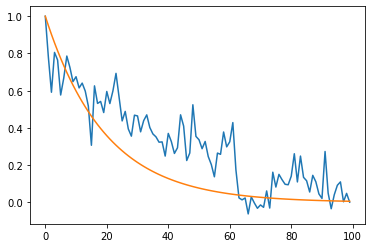

In [8]:
p_array = params.data.numpy()
p_array = p_array.reshape(-1)
p_array = p_array / p_array[0]
plt.plot(np.arange(days), p_array)
plt.plot(np.arange(days), [0.95 ** i for i in range(days)])